<a href="https://colab.research.google.com/github/SUN-Wenjun/Trump_Tweet_Generator/blob/master/trumpy_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/My Drive/TrumpTweetGenerator

/content/gdrive/My Drive/TrumpTweetGenerator


In [0]:
pip install markovify

In [0]:
import markovify

In [4]:
# import resources
from google.colab import files

import numpy as np
import pandas as pd
import json
import os
import random
import re

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


import spacy

from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
pd.set_option('max_colwidth',500)
random.seed(5067)

## Get Trump's tweets

In [0]:
# result datafram
df_trumptweet = pd.DataFrame()

In [0]:
# read in tweets of each year and append them to the result dataframe
for data_file in os.listdir('data/trumptweet/'):
    df = pd.read_json('data/trumptweet/' + data_file)
    df_trumptweet = df_trumptweet.append(df)

In [18]:
len(df_trumptweet)

36307

## Get other people's tweets

In [0]:
df_othertweet = pd.DataFrame()

In [20]:
!ls 'data/othertweet/'

BarackObama.csv					HillaryClintonTweets.csv
HillaryClinton2014-01-01To2016-10-14Tweets.csv	KimKardashianTweets.csv


In [60]:
for data_file in os.listdir('data/othertweet/'):
    df = pd.read_csv('data/othertweet/' + data_file, engine='python')
    df_othertweet = df_othertweet.append(df, ignore_index  = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [22]:
len(df_othertweet)

24196

## Proprecessing

### remove retweets

In [0]:
df_trumptweet = df_trumptweet[df_trumptweet['is_retweet']==False]

In [0]:
df_othertweet = df_othertweet[['date', 'id', 'retweet', 'text', 'author']]
df_othertweet = df_othertweet[df_othertweet['retweet']==False]

### clean tweet

In [0]:
def clean_tweet(text):
    # remove quotes
    text = re.sub(r'"@.*', '', text)
    text = re.sub(r'^“.*”$', '', text)
    # remove URLs
    text = re.sub(r'https*:\/\/\S*', '', text)
    # remove \n
    text = re.sub('\n', ' ', text)
    # replace '&amp' with 'and'
    text = re.sub('&amp;', 'and', text)
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    # remove picture link
    text = re.sub(r'pic\.twitter\.com\/\S*', '', text)
    return(text)

In [0]:
df_trumptweet['cleaned_text'] = list(map(clean_tweet, df_trumptweet['text']))

In [0]:
df_othertweet['cleaned_text'] = list(map(clean_tweet, df_othertweet['text']))

### remove empty tweets

In [0]:
df_trumptweet['cleaned_text'].replace(' ', np.nan, inplace = True)
df_trumptweet['cleaned_text'].replace('', np.nan, inplace = True)
df_trumptweet.dropna(subset = ['cleaned_text'], inplace = True)

In [0]:
df_othertweet['cleaned_text'].replace(' ', np.nan, inplace = True)
df_othertweet['cleaned_text'].replace('', np.nan, inplace = True)
df_othertweet.dropna(subset = ['cleaned_text'], inplace = True)

In [30]:
len(df_trumptweet), len(df_othertweet)

(24595, 24127)

### save data


In [0]:
df_trumptweet['cleaned_text'].to_csv( 'trumptweet_cleaned_text.csv', index = False)
# pd.read_csv('trumptweet_cleaned_text.csv', names = ['cleaned_text'])

In [0]:
df_trumptweet.to_csv( 'trumptweet.csv')
df_othertweet.to_csv( 'othertweet.csv')

In [0]:
# df_trumptweet = pd.read_csv('trumptweet.csv', lineterminator='\n', index_col=0)
# df_othertweet = pd.read_csv('othertweet.csv', lineterminator='\n', index_col=0)

## Classifier Modeling

#### Prepare data for classifier

In [46]:
# combine Trump and other's tweets
df_t = df_trumptweet[['cleaned_text']]
df_t['author'] = 1 # 1 = trump
df_o = df_othertweet[['cleaned_text']]
df_o['author'] = 0 # 0 = non-trump

df_combine = df_t.append(df_o)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
def prepare_tweet_clf(t):
    # clean
    t = t.lower()
    t = re.sub("'ll", ' will', t) # replace abbreviations
    t = re.sub("won't", 'will not', t)
    t = re.sub("n't", ' not', t)
    t = re.sub(r'@[A-Za-z0-9_]+', '', t) # remove @mention
    t = re.sub(r'#[A-Za-z0-9_]+', '', t) # remove #tag
    t = re.sub(r'[^a-zA-Z ]', '', t) # remove special characters

    # remove stopwords
    stop = set(stopwords.words('english'))
    stop.update(['rt', 'cc'])
    stop = stop - set(['no', 'not', 'never'])
    t = [word for word in t.split(' ') if word not in stop]
    t = ' '.join(t)
    return t

In [0]:
df_combine['cleaned_text_clf'] = list(map(prepare_tweet_clf, df_combine['cleaned_text']))

In [0]:
# save data
df_combine.to_csv( 'combinetweet.csv')

In [0]:
# load data
# df_combine = pd.read_csv('combinetweet.csv', lineterminator='\n', index_col=0)

In [0]:
# split into train, test, validation
df_train, df_notrain = train_test_split(df_combine, test_size=0.2)
df_test, df_validation = train_test_split(df_notrain, test_size=0.5)

x_train, y_train = df_train['cleaned_text_clf'], df_train['author']
x_notrain, y_notrain = df_notrain['cleaned_text_clf'], df_notrain['author']
x_test, y_test = df_test['cleaned_text_clf'], df_test['author']
x_validation, y_validation = df_validation['cleaned_text_clf'], df_validation['author']

In [53]:
len(x_train), len(x_notrain), len(x_validation), len(x_test)

(38977, 9745, 4873, 4872)

#### Multinomial Naive Bayes model

##### define model

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

##### train model

In [29]:
score = 'precision'  # optimize against precision (= true Trump / predicted to be Trump) 
np.errstate(divide='ignore')
model_clf_nb = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring=score)
model_clf_nb.fit(x_train, y_train)

print("Best parameters set found on training set:", model_clf_nb.best_params_)

Best parameters set found on training set: {'clf__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 3)}


##### save model

In [32]:
from joblib import dump
dump(model_clf_nb, 'model_clf_NB.joblib') 

['model_clf_NB.joblib']

##### load model

In [0]:
from joblib import load
model_clf_nb = load('model_clf_NB.joblib') 

##### print statistics

              precision    recall  f1-score   support

           0     0.9804    0.9772    0.9788      4822
           1     0.9777    0.9809    0.9793      4923

    accuracy                         0.9791      9745
   macro avg     0.9791    0.9790    0.9791      9745
weighted avg     0.9791    0.9791    0.9791      9745



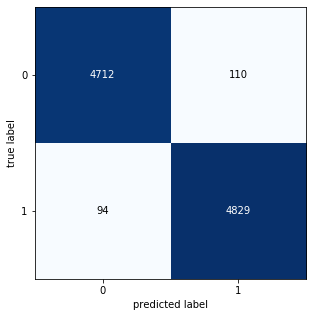

In [55]:
from sklearn.metrics import classification_report
print(classification_report(y_notrain, model_clf_nb.predict(x_notrain), digits=4))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_notrain, model_clf_nb.predict(x_notrain))
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

#### LSTM classifier model

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##### load data

In [113]:
max_length = 30
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_len=49999

tokenizer = Tokenizer(num_words=vocab_len+1, oov_token=oov_tok)
tokenizer.fit_on_texts(x_test)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print('Size of Vocabulary: ',vocab_size)

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(x_validation)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

y_train = np.expand_dims(y_train, axis=1)
y_validation = np.expand_dims(y_validation, axis=1)

Size of Vocabulary:  8510


In [115]:
# # download word embedding
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove*.zip

Archive:  glove.twitter.27B.zip
replace glove.twitter.27B.25d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.twitter.27B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.twitter.27B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.twitter.27B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
embeddings_index1 = {}
with open('glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index1[word] = coefs
f.close()

In [117]:
embedding_dim1=200
embeddings_matrix1 = np.zeros((vocab_size, embedding_dim1))
for word, i in word_index.items():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        embeddings_matrix1[i-1] = embedding_vector
print('Shape of the Embeddings Matrix (GloVe Twitter): ',embeddings_matrix1.shape)

Shape of the Embeddings Matrix (GloVe Twitter):  (8510, 200)


##### define model

In [0]:
model_clf_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim1, input_length=max_length, weights = [embeddings_matrix1], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##### train model

In [119]:
reduce = tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
model_clf_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 20
history1 = model_clf_lstm.fit(train_padded, 
                                              y_train, 
                                              epochs=num_epochs, 
                                              batch_size=256, 
                                              validation_data=(val_padded,y_validation),
                                              callbacks=[reduce],
                                              verbose=1)

Train on 38977 samples, validate on 4873 samples
Epoch 1/20
38977/38977 [==============================] - 19s 495us/sample - loss: 0.6061 - acc: 0.6571 - val_loss: 0.5159 - val_acc: 0.7496
Epoch 2/20
38977/38977 [==============================] - 4s 105us/sample - loss: 0.4920 - acc: 0.7589 - val_loss: 0.4048 - val_acc: 0.8198
Epoch 3/20
38977/38977 [==============================] - 4s 105us/sample - loss: 0.4187 - acc: 0.8097 - val_loss: 0.3541 - val_acc: 0.8414
Epoch 4/20
38977/38977 [==============================] - 4s 105us/sample - loss: 0.3748 - acc: 0.8342 - val_loss: 0.3795 - val_acc: 0.8165
Epoch 5/20
38977/38977 [==============================] - 4s 105us/sample - loss: 0.3432 - acc: 0.8503 - val_loss: 0.3049 - val_acc: 0.8693
Epoch 6/20
38977/38977 [==============================] - 4s 104us/sample - loss: 0.3194 - acc: 0.8626 - val_loss: 0.3048 - val_acc: 0.8607
Epoch 7/20
38977/38977 [==============================] - 4s 105us/sample - loss: 0.3053 - acc: 0.8690 - val_l

##### save model

In [0]:
timestring = datetime.now().strftime('%Y%m%d_%H%M%S')
file_name = 'model_clf_lstm_{}.json'.format(timestring)
weight_name = 'model_clf_lstm_weight_{}.h5'.format(timestring)

# serialize model to JSON
clf_lstm_model_json = model_clf_lstm.to_json()
with open(file_name, 'w') as json_file:
    json_file.write(clf_lstm_model_json)

# serialize weights to HDF5
model_clf_lstm.save_weights(weight_name)

##### load model

In [111]:
# load model
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('clf_lstm_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_clf_lstm = model_from_json(loaded_model_json)
# load weights into new model
model_clf_lstm.load_weights('clf_lstm_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


##### print some statistics

4872/4872 [==============================] - 7s 1ms/sample
              precision    recall  f1-score   support

           0     0.9008    0.8885    0.8946      2431
           1     0.8905    0.9025    0.8964      2441

    accuracy                         0.8955      4872
   macro avg     0.8956    0.8955    0.8955      4872
weighted avg     0.8956    0.8955    0.8955      4872



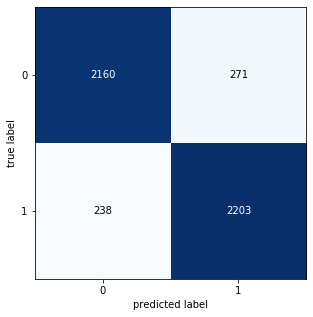

In [121]:
pred_test = model_clf_lstm.predict(test_padded, batch_size=256,  verbose=1)
pred_test_labels = (pred_test>0.5).astype(int)

print(classification_report(y_test, pred_test_labels, digits=4))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, pred_test_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

#### Application of the classifier

In [0]:
def tweets_report(tweet_list):
    proba_list = model_clf_nb.predict_proba(tweet_list)[:,1]

    index_max = np.argmax(proba_list)
    q3_index = np.argsort(proba_list)[len(proba_list)-len(proba_list)//4]
    median_index = np.argsort(proba_list)[len(proba_list)//2]

    dummy_list = list(map(lambda x : (x>0.5).astype(int), proba_list))

    print('Proportion of tweets fooled the classifier: ', np.mean(dummy_list), '\n',
    'The best tweet: ', tweet_list[index_max], np.max(proba_list), '\n',
    'The 75th percentile tweet: ', tweet_list[q3_index], proba_list[q3_index], '\n',
    'The median tweet: ', tweet_list[median_index], proba_list[median_index])


## Generator Modeling

### Markov Chain Model

#### baseline model

##### load data

In [0]:
# markovify takes string as input
training_text = '.'.join(df_trumptweet['cleaned_text'])

##### train model

In [0]:
model_markov_baseline = markovify.Text(training_text)

##### save model

In [0]:
with open('markov_baseline.json', 'w') as f:
    json.dump(model_markov_baseline.to_json(), f)

##### load model

In [0]:
# with open('markov_baseline.json') as f:    
#     model_markov_baseline = json.load(f)

##### print statistics & generate sentences

In [0]:
# generate sentence
sentence_markov_baseline = []
for _ in range(1000):
    sentence = model_markov_baseline.make_short_sentence(140)
    sentence_markov_baseline.append(sentence)
    #print(sentence)

In [127]:
tweets_report(sentence_markov_baseline)

Proportion of tweets fooled the classifier:  0.93 
 The best tweet:  From a large shipment of military weapons and supplies to my GREAT members at Trump International Golf Links in Scotland! 0.9999707653840255 
 The 75th percentile tweet:  Watch it, should be ashamed for using the celebrity’s name followed by new champion Chris Weidman! 0.9848810213321352 
 The median percentile tweet:  #Debates .USA has the guts to even greater unemployment. 0.9406103707039736


#### '3-grams' model

Using three - instead of two - words ahead to predic the following word. 

In [0]:
training_text = '.'.join(df_trumptweet['cleaned_text'])

In [0]:
model_markov_3gram = markovify.Text(training_text, state_size=3)

In [0]:
with open('markov_3gram.json', 'w') as f:
    json.dump(model_markov_3gram.to_json(), f)

In [0]:
# with open('markov_3gram.json') as f:    
#     model_markov_3gram = json.load(f)

In [0]:
sentence_markov_3gram = []
for _ in range(1000):
    sentence = model_markov_3gram.make_short_sentence(140)
    sentence_markov_3gram.append(sentence)

In [128]:
tweets_report(sentence_markov_3gram)

Proportion of tweets fooled the classifier:  0.946 
 The best tweet:  The Rigged Witch Hunt headed by 13 Angry Democrats and others who are totally corrupt and/or conflicted. 0.9999878115987703 
 The 75th percentile tweet:  Thank you, a very wise move that Ted Cruz FORGOT to file. 0.9875842721781313 
 The median percentile tweet:  In the meantime they continue to be drawn to it. 0.9554522093898657


#### add POS, state_size = 3 to model

##### define model

In [0]:
nlp = spacy.load("en")

class POSifiedText(markovify.Text):

    def word_split(self, sentence):
        return ["::".join((word.orth_, word.pos_)) for word in nlp(sentence)]

    def word_join(self, words):
        sentence = " ".join(word.split("::")[0] for word in words)

        return sentence

In [0]:
model_markov_pos = POSifiedText(training_text, state_size=3)

##### save model

In [0]:
with open('model_markov_pos.json', 'w') as f:
    json.dump(model_markov_pos.to_json(), f)

##### load model

In [0]:
# with open('markov_basic.json') as f:    
#     model_markov_basic = json.load(f)

##### print statistics & generate sentences

In [0]:
sentence_markov_pos = []
for _ in range(1000):
    sentence = model_markov_pos.make_short_sentence(140)
    sentence_markov_pos.append(sentence)

In [131]:
tweets_report(sentence_markov_pos)

Proportion of tweets fooled the classifier:  0.947 
 The best tweet:  We want victory .. Trump International Golf Links Scotland . 0.9999837412710088 
 The 75th percentile tweet:  I will beat Hillary easily , but Lindsey Graham says I wo n't be around much longer , it 's called Envy . 0.986747834772992 
 The median percentile tweet:  .On behalf of an entire Nation , THANK YOU for today 's update and GREAT WORK ! 0.9502348960281569


### LSTM RNN model

In [0]:
!pip install -q textgenrnn

In [58]:
from textgenrnn import textgenrnn

Using TensorFlow backend.


In [0]:
trumptweet_list = list(df_trumptweet['cleaned_text'])
trumptweet_file = open("trumptweet_text.txt","w+")
trumptweet_list = "\n".join(trumptweet_list)
trumptweet_file.writelines(trumptweet_list)
trumptweet_file.close() 

#### character-level

##### load data

In [0]:
file_name = "trumptweet_text.txt"
model_name = 'model_rnn_char'

In [59]:
# df_trumptweet['cleaned_text'].to_csv( 'trumptweet_cleaned_text.csv', index = False)
# file_name = 'trumptweet_cleaned_text.csv'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


##### define model

In [0]:
model_cfg_char = {
    'word_level': False,   # set to True if want to train a word-level model (requires more data and smaller max_length)
    'rnn_size': 128,   # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 3,   # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': True,   # consider text both forwards and backward, can give a training boost
    'max_length': 30,   # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
    'max_words': 10000,   # maximum number of words to model; the rest will be ignored (word-level model only)
}

train_cfg_char = {
    'line_delimited': True,   # set to True if each text has its own line in the source file
    'num_epochs': 20,   # set higher to train the model for longer
    'gen_epochs': 10,   # generates sample text from model after given number of epochs
    'train_size': 0.8,   # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'dropout': 0.0,   # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'validation': True,   # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'is_csv': False   # set to True if file is a CSV exported from Excel/BigQuery/pandas
}

##### train model

In [99]:
textgen_char = textgenrnn(name=model_name)

train_function_char = textgen_char.train_from_file if train_cfg_char['line_delimited'] else textgen_char.train_from_largetext_file

train_function_char(
    file_path=file_name,
    new_model=True,
    num_epochs=train_cfg_char['num_epochs'],
    gen_epochs=train_cfg_char['gen_epochs'],
    batch_size=1024, 
    train_size=train_cfg_char['train_size'],
    dropout=train_cfg_char['dropout'],
    validation=train_cfg_char['validation'],
    is_csv=train_cfg_char['is_csv'],
    rnn_layers=model_cfg_char['rnn_layers'],
    rnn_size=model_cfg_char['rnn_size'],
    rnn_bidirectional=model_cfg_char['rnn_bidirectional'],
    max_length=model_cfg_char['max_length'],
    dim_embeddings=100,
    word_level=model_cfg_char['word_level'])

24,594 texts collected.
Training new model w/ 3-layer, 128-cell Bidirectional LSTMs
Training on 2,182,817 character sequences.
Epoch 1/20
2131/2131 [==============================] - 330s 155ms/step - loss: 1.8683 - val_loss: 1.4832
Epoch 2/20
2131/2131 [==============================] - 327s 153ms/step - loss: 1.4100 - val_loss: 1.3845
Epoch 3/20
2131/2131 [==============================] - 327s 153ms/step - loss: 1.3249 - val_loss: 1.3347
Epoch 4/20
2131/2131 [==============================] - 325s 152ms/step - loss: 1.2770 - val_loss: 1.3137
Epoch 5/20
2131/2131 [==============================] - 327s 153ms/step - loss: 1.2421 - val_loss: 1.2933
Epoch 6/20
2131/2131 [==============================] - 326s 153ms/step - loss: 1.2138 - val_loss: 1.2769
Epoch 7/20
2131/2131 [==============================] - 326s 153ms/step - loss: 1.1883 - val_loss: 1.2659
Epoch 8/20
2131/2131 [==============================] - 327s 153ms/step - loss: 1.1652 - val_loss: 1.2586
Epoch 9/20
2131/2131 [===

##### save model

The model saves the weights automatically after each epoch. 

##### load model

In [0]:
textgen = textgenrnn(weights_path=model_name+'_weights.hdf5',
                                  vocab_path=model_name+'_vocab.json',
                                  config_path=model_name+'_config.json')

##### print statistics and generate sentences

In [0]:
temperature = [0.5]   
prefix = None  

if train_cfg_char['line_delimited']:
  n = 1000
  max_gen_length = 60 if model_cfg_char['word_level'] else 300
else:
  n = 1
  max_gen_length = 2000 if model_cfg_char['word_level'] else 10000

sentences_char = textgen_char.generate(n=n, temperature=0.5, max_gen_length = 280, return_as_list=True)

In [102]:
tweets_report(sentences_char)

Proportion of tweets fooled the classifier:  0.985 
 The best tweet:  .@marklevinshow interview discussing the Celebrity Apprentice and Crooked Hillary Clinton will only get born in the world. I will be the best thing to have the haters and the truth in the New York Times - just reported that I am the only one that the Fake News Media will do a g 0.9999960971624224 
 The 75th percentile tweet:  My @SquawkCNBC interview discussing the boardroom of the United States of Americans will be a great deal for the fact that China is always going to be the greatest of the world, and all others, get ready for a winner! 0.9959520972232001 
 The median tweet:  A MUST has spent records and positive process of Edwarding to President Obama for a failed policy in the tragic deal done by @SecretaryZinkens will be a great guy who spends and the field in the U.S. Military will be a disgrace to the American people and the victims of the Stoc 0.9798632189690395


In [0]:
# save the list (1000 generated tweets)
charlevel_file = open("generated_tweet_charlevel.txt","w+")
sentences_char_temp = "\n".join(sentences_char)
charlevel_file.writelines(sentences_char_temp)
charlevel_file.close() 

#### word-level

##### load data

In [0]:
file_name = "trumptweet_text.txt"
model_name = 'model_rnn_word'

##### define model

In [0]:
model_cfg_word = {
    'word_level': True,   # set to True if want to train a word-level model (requires more data and smaller max_length)
    'rnn_size': 256,   # number of LSTM cells of each layer (128/256 recommended)
    'rnn_layers': 3,   # number of LSTM layers (>=2 recommended)
    'rnn_bidirectional': True,   # consider text both forwards and backward, can give a training boost
    'max_length': 8,   # number of tokens to consider before predicting the next (20-40 for characters, 5-10 for words recommended)
    'max_words': 10000,   # maximum number of words to model; the rest will be ignored (word-level model only)
}

train_cfg_word = {
    'line_delimited': True,   # set to True if each text has its own line in the source file
    'num_epochs': 30,   # set higher to train the model for longer [# it was 20]
    'gen_epochs': 10,   # generates sample text from model after given number of epochs
    'train_size': 0.8,   # proportion of input data to train on: setting < 1.0 limits model from learning perfectly
    'dropout': 0.0,   # ignore a random proportion of source tokens each epoch, allowing model to generalize better
    'validation': True,   # If train__size < 1.0, test on holdout dataset; will make overall training slower
    'is_csv': False   # set to True if file is a CSV exported from Excel/BigQuery/pandas
}

##### train model

In [106]:
textgen_word = textgenrnn(name=model_name)

train_function_word = textgen_word.train_from_file if train_cfg_word['line_delimited'] else textgen_word.train_from_largetext_file

train_function_word(
    file_path=file_name,
    new_model=True,
    num_epochs=train_cfg_word['num_epochs'],
    gen_epochs=train_cfg_word['gen_epochs'],
    batch_size=1024, 
    train_size=train_cfg_word['train_size'],
    dropout=train_cfg_word['dropout'],
    validation=train_cfg_word['validation'],
    is_csv=train_cfg_word['is_csv'],
    rnn_layers=model_cfg_word['rnn_layers'],
    rnn_size=model_cfg_word['rnn_size'],
    rnn_bidirectional=model_cfg_word['rnn_bidirectional'],
    max_length=model_cfg_word['max_length'],
    dim_embeddings=100,
    word_level=model_cfg_word['word_level'])

24,594 texts collected.
Training new model w/ 3-layer, 256-cell Bidirectional LSTMs
Training on 484,200 word sequences.
Epoch 1/30
472/472 [==============================] - 91s 193ms/step - loss: 6.0433 - val_loss: 5.1758
Epoch 2/30
472/472 [==============================] - 87s 185ms/step - loss: 4.7993 - val_loss: 4.8121
Epoch 3/30
472/472 [==============================] - 89s 188ms/step - loss: 4.2842 - val_loss: 4.7168
Epoch 4/30
472/472 [==============================] - 88s 187ms/step - loss: 3.8224 - val_loss: 4.7920
Epoch 5/30
472/472 [==============================] - 88s 187ms/step - loss: 3.3722 - val_loss: 4.9127
Epoch 6/30
472/472 [==============================] - 89s 188ms/step - loss: 2.9538 - val_loss: 5.0809
Epoch 7/30
472/472 [==============================] - 89s 188ms/step - loss: 2.5777 - val_loss: 5.2312
Epoch 8/30
472/472 [==============================] - 88s 187ms/step - loss: 2.2443 - val_loss: 5.4092
Epoch 9/30
472/472 [==============================] - 89

##### save model

The model saves the weights automatically after each epoch. 

##### load model

In [0]:
textgen_word = textgenrnn(weights_path=model_name+'_weights.hdf5',
                                                    vocab_path=model_name+'_vocab.json',
                                                    config_path=model_name+'_config.json')

##### print statistics and generate sentenses

In [0]:
temperature = [0.5]   
prefix = None  

if train_cfg_small['line_delimited']:
  n = 1000
  max_gen_length = 60 if model_cfg_word['word_level'] else 300
else:
  n = 1
  max_gen_length = 2000 if model_cfg_word['word_level'] else 10000

sentences_word = textgen_word.generate(n=n, temperature=0.5, max_gen_length = 140, return_as_list=True)

In [123]:
tweets_report(sentences_word)

Proportion of tweets fooled the classifier:  0.967 
 The best tweet:  the big story that the fake news media refuses to report me for @ cnn . my great honor to speak at the @ ussarizona . thank you ! # trump2016 0.999961919339227 
 The 75th percentile tweet:  " i have great respect for the people that represent the united us care . remember that the great president ? he is a nice guy ! 0.9771959667746702 
 The median tweet:  . @ hillaryclinton is on the front page of the illinois . . . but write a . that ’ s because it should be an economic failure ' s to mexico . the problem ' 12 . you are both more . 0.8993477128327447


In [0]:
# save the list (1000 generated tweets)
wordlevel_file = open("generated_tweet_wordlevel.txt","w+")
sentences_word_temp = "\n".join(sentences_word)
wordlevel_file.writelines(sentences_word_temp)
wordlevel_file.close() 

## reference

NB classifier 
https://towardsdatascience.com/sentiment-analysis-of-tweets-using-multinomial-naive-bayes-1009ed24276b

LSTM classifier
https://github.com/manashpratim/Tweet-Classification/blob/master/Tweet_Classification.ipynb

textgenrnn (LSTM text generator)
https://github.com/minimaxir/textgenrnn